In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps
from scipy.integrate import quad
from scipy.special import gamma
import scipy.optimize as optimize


Основные функции

In [22]:
# DataFrame c реализацией процесса авторегресси p-го порядка и его зашумленного варианта 
def ar_p(n, theta, sigma, Delta):
    x = np.random.normal(0,sigma,len(theta))
    y = x.copy()
    for i in range(n):
        x = np.append(x,(np.sum(theta*x[-len(theta):][::-1])+np.random.normal(0,sigma,1)))
        y = np.append(y,x[-1]+np.random.normal(0,Delta,1))
        z = np.stack((x,y),axis = 1)
    data = pd.DataFrame(z,columns=['ARp', 'ARp_noised'])
    return data



# Оценка МНК параметра процесса AR(p)
def LSE_n1(y,theta,n_1):
    p=len(theta)
    y=np.array(y)
    num = 0
    den = np.zeros((p,p))
    for i in range(p+1, n_1):
        num += y[i]*y[i-1:i-p-1:-1]
        den += y[i-1:i-p-1:-1].reshape((p,1)) @ y[i-1:i-p-1:-1].reshape((1,p))
    return np.linalg.inv(den) @ num.reshape((p,1))


# Оценка Юла-Уокера
def UW_n1(y,theta,n1):
    theta = np.array(theta)
    p = len(theta)
    y=np.array(y)
    num = 0
    den = np.zeros((p,p))
    for i in range(2*p+1, n1):
        num += y[i]*y[i-p-1:i-2*p-1:-1]
        den += y[i-p-1:i-2*p-1:-1].reshape((p,1)) @ y[i-1:i-p-1:-1].reshape((1,p))
    return np.linalg.inv(den) @ num.reshape((p,1))

def lb_conf_prob(y, z, n2):
    return((2*sps.norm.cdf(z * (y / (2 * (n2-2))) ** 0.5) - 1) * sps.chi2.pdf(y,n2))


# Построение полуинтервала
def seq_est_i_semiint(h, n1, n2, theta, sigma, Delta, alpha):
    if(alpha<=0 and alpha>=1):
        print('Неверно задано alpha')
        return(0);
    theta = np.array(theta)
    p = 1
    x = np.array(np.random.normal(0, sigma, p))
    y = x.copy()+np.random.normal(0, Delta, p)
    sum_gamma = 0
    tau = np.zeros((p+1,1))
    sum_xk_sq = np.zeros((p+1, 1)) #
    alphas = np.zeros((p+1, 1))
    G_vec = np.zeros((p+1, 1))
    vartheta_vec = np.zeros((p+1, 1))
    theta_est_seq = np.zeros((p+1, 1))
    l = 0
    
    
    ######################
    #Пилотная оценка theta
    for i in range(n1):
        x = np.append(x, (theta * x[-1] + np.random.normal(0, sigma, 1)))
        y = np.append(y, x[-1] + np.random.normal(0, Delta, 1))
    theta_est = UW_n1(y,theta,n1)
    if(theta_est > 1): theta_est = 1
    elif(theta_est < -1): theta_est = -1
    theta_est = float(theta_est)
    
    
    #######################
    #Оценка дисперсии шума
    for k in range(n2):
        x = np.append(x, (theta * x[-1] + np.random.normal(0, sigma, 1)))
        y = np.append(y, x[-1] + np.random.normal(0, Delta, 1))
        sum_gamma += (y[-1] - y[-2] * theta_est) ** 2
    sum_gamma = 1 / (n2 - 2) * float(sum_gamma)

    
    #######################
    # Дополнительные наблюдения для соблюдения свойства мартингальности
    for t in range(p):
        x = np.append(x, (theta * x[-1] + np.random.normal(0, sigma, 1)))
        y = np.append(y, x[-1] + np.random.normal(0, Delta, 1))
    
    
    #######################        
    #Система последовательных оценок
    while(l<p+1):
        x = np.append(x, (theta * x[-1] + np.random.normal(0, sigma, 1)))
        y = np.append(y, x[-1] + np.random.normal(0, Delta, 1))
        
        no_est = len(y) % (p+1)
        if(tau[no_est] == 0):
            sum_xk_sq[no_est] += y[-1-(p+1)] ** 2 / sum_gamma
            vartheta_vec[no_est] += y[-1-(p+1)] * y[-1]
            G_vec[no_est] += y[-1-(p+1)] * y[-2]
            if(sum_xk_sq[no_est] >= h):
                tau[no_est] = len(y)
                alphas[no_est] = (h - (sum_xk_sq[no_est] - y[-1-(p+1)] ** 2 / sum_gamma)) / (y[-1-(p+1)] ** 2 / sum_gamma)
                vartheta_vec[no_est] += (alphas[no_est] ** 0.5 - 1) * y[-1-(p+1)] * y[-1]
                G_vec[no_est] += (alphas[no_est] ** 0.5 - 1) * y[-1-(p+1)] * y[-2]
                theta_est_seq[no_est] = G_vec[no_est] ** (-1) * vartheta_vec[no_est]
                l += 1
   

    #######################                         
    # Вычисление квантиля
    lb_cf = lambda z : 2 * quad(lb_conf_prob, 0, np.inf, args = (z, n2))[0] - 1 - (1 - alpha)
    mu = 0
    z_max = 10
    while(mu < 10 ** (-10)):
        try:
            mu = optimize.bisect(lb_cf, 0, z_max)
        except ValueError:
            z_max *=2
    
    
    #######################                         
    # Вычисление интервала
    theta_bar = np.mean(theta_est_seq)
    delt = mu * sum_gamma * h ** 0.5 / np.min(np.abs(G_vec))
    bias_est =  abs(theta_bar - theta)
    tau_max = np.max(tau)
    data = np.array([1-alpha, h, float(theta), sigma**2, Delta**2, float(bias_est), delt,  int(tau_max),  int(bias_est < delt)])
    df = data.reshape((1, len(data)))
    return pd.DataFrame(df, columns = ('1-alpha','h','theta','sigma^2', 'Delta^2', 'bias_est', 'semiint', 'tau_max', 'ind_cover'))

Пример зашумленного процесса AR(1)

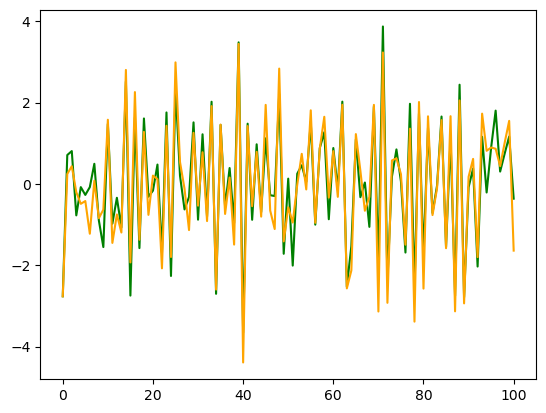

In [39]:
n=100                         # объем выборки
theta = np. array([-0.6])     # значение параметра
sigma = 1.1                   # СКО управляющего шума
Delta = 0.5                   # СКО аддитивной ошибки
ar = ar_p(n, theta, sigma, Delta)
plt.plot(ar['ARp'], color = 'green')
plt.plot(ar['ARp_noised'], color = 'orange')


Пример реализации процедуры построения доверителельного интервала

In [24]:
h = 1000 
n1 = 20
n2 = 15
theta = np.array([0.7])
sigma = 1.1
Delta = 0.6
alpha = 0.1

seq_est_i_semiint(h, n1, n2, theta, sigma, Delta, alpha)

,1-alpha,h,theta,sigma^2,Delta^2,bias_est,semiint,tau_max,ind_cover
0,0.9,1000.0,0.7,1.21,0.36,0.009979,0.141676,1516.0,1.0


здесь
1-alpha -- нижняя граница доверительной вероятности,
h -- параметр, отвечающий за средний объем выборки,
theta -- значение параметра процесса AR(1),
sigma^2 -- дисперсия управляющего шума процесса AR(1),
Delta^2 -- дисперсия аддитивной ошибки,
bias_est -- модуль смещения оценки,
semiint -- длина полуинтервала интервальной оценки,
tau_max -- требуемый объем выборки,
ind_cover -- индикатор накрытия истинного значения параметра theta доверительным интервалом.
